[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biodatlab/deep-learning-skooldio/blob/master/student_notebooks/04_pytorch_for_tabular_data.ipynb)


## **Predicting second hand car price from Rodkaidee: Regression**

This notebook contains the following steps for predicting second hand car price from [Rodkaidee website](https://rod.kaidee.com/)

- Import libraries
- Prepare data: Categorical and numerical features
- Train linear regression model
- Train one-layer neural network model for regression (equivalent to linear regression)
- Train multi-layer neural network model for regression

In [1]:
import os
import os.path as op

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib

## **Data Preparation**

- Download data from [`github.com/biodatlab/deep-learning-skooldio`](https://github.com/biodatlab/deep-learning-skooldio)
- Clean and split data

In [2]:
!git clone https://github.com/biodatlab/deep-learning-skooldio

Cloning into 'deep-learning-skooldio'...
remote: Enumerating objects: 1834, done.
remote: Counting objects: 100% (1834/1834), done.
remote: Compressing objects: 100% (1794/1794), done.
remote: Total 1834 (delta 74), reused 1792 (delta 40), pack-reused 0
Receiving objects: 100% (1834/1834), 13.55 MiB | 14.38 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [3]:
df = pd.read_csv(op.join("deep-learning-skooldio", "rodkaidee-dataset", "Rodkaidee Data.csv"))
df.head(5)

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color
0,Mazda,Mazda2,1.3,B-Segment,2022,"15,640",กรุงเทพมหานคร,"499,000",Gray
1,Suzuki,Celerio,1.0,Eco Car,2021,"9,545",กรุงเทพมหานคร,"315,000",White
2,Mitsubishi,Mirage,1.2,Eco Car,2021,"10,900",นนทบุรี,"335,000",Gray
3,Nissan,March,1.2,Eco Car,2021,"12,000",กรุงเทพมหานคร,"339,000",Silver
4,Mitsubishi,Attrage,1.2,Eco Car,2021,"25,706",กาญจนบุรี,"350,000",Gray


## Clean and split data 

In [4]:
import os.path as op

# TODOs: Clean price and mileage from string to float
df["Mileage"] = df["Mileage"].apply(lambda x: float(x.replace(",", "")))
df["Price"] = df["Price"].apply(lambda x: float(x.replace(",", "")))

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
df_train.head()

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color
6370,Toyota,Vios,1.5,B-Segment,2008,150000.0,สงขลา,259000.0,Gray
3915,Toyota,Altis,1.8,C-Segment,2013,101266.0,กรุงเทพมหานคร,299000.0,Black
7194,Honda,Civic,1.7,C-Segment,2003,280000.0,สระบุรี,119000.0,Gold
2318,Mazda,Mazda3,2.0,C-Segment,2016,74111.0,กรุงเทพมหานคร,430000.0,Silver
6677,Toyota,Camry,2.0,D-Segment,2007,263489.0,กรุงเทพมหานคร,288000.0,Brown


In [6]:
len(df_train), len(df_val)

(5916, 1480)

## Apply One-hot Encoding to categorical values

For example, if a column has three unique values 'A', 'B', and 'C', rows that contain 'C' will be transformed to [0, 0, 1].

In [12]:
# TODOs: Create one-hot encoder for categorical columns
CAT_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]

ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
cat_train_array = ohe.fit_transform(df_train[CAT_COLUMNS])

In [13]:
cat_val_array = ohe.transform(df_val[CAT_COLUMNS])

In [16]:
cat_train_array.shape, cat_val_array.shape

((5916, 136), (1480, 136))

## Normalize continuous values

We will use `MinMaxScaler` to normalize continuous value.
For example, column X has values from 0 to 1000000, so we need to normalize them to 0 to 1.
Alternatively `StandardScaler` is also an option.

In [21]:
# TODOs: Create MinMaxScaler for numerical (continuous) columns
year_scaler = MinMaxScaler()
mileage_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

In [22]:
scaled_year = year_scaler.fit_transform(df_train[["Year"]])
scaled_mileage = mileage_scaler.fit_transform(df_train[["Mileage"]])
scaled_price = price_scaler.fit_transform(df_train[["Price"]])

## Apply one-hot encoding and normalization to create train and teset dataset

In [25]:
# TODOs: Apply one-hot encoder and MinMaxScaler to the training and validation dataframe 
X_train = np.hstack([
    ohe.transform(df_train[CAT_COLUMNS]),
    year_scaler.transform(df_train[["Year"]]),
    mileage_scaler.transform(df_train[["Mileage"]])
])
y_train = price_scaler.transform(df_train[["Price"]])

X_val = np.hstack([
    ohe.transform(df_val[CAT_COLUMNS]),
    year_scaler.transform(df_val[["Year"]]),
    mileage_scaler.transform(df_val[["Mileage"]])
])
y_val = price_scaler.transform(df_val[["Price"]])

In [26]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5916, 138), (5916, 1), (1480, 138), (1480, 1))

In [27]:
# save one-hot encoder and scaler objects with joblib
save_dir = "trained_models"
os.makedirs(save_dir, exist_ok=True)
joblib.dump(ohe, op.join(save_dir, "one_hot_encoder.joblib"))
joblib.dump(year_scaler, op.join(save_dir, "year_scaler.joblib"))
joblib.dump(mileage_scaler, op.join(save_dir, "mileage_scaler.joblib"))
joblib.dump(price_scaler, op.join(save_dir, "price_scaler.joblib"))

['trained_models/price_scaler.joblib']

## **Train a Linear Regression Model**

In [28]:
# TODO: create a linear regression model and fit to the training data.
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred_lr = lr_model.predict(X_val)
y_pred_lr.shape

(1480, 1)

In [31]:
df_val["Predicted_Price_LR"] = price_scaler.inverse_transform(y_pred_lr).ravel()

In [32]:
df_val

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color,Predicted_Price_LR
2759,Toyota,Vios,1.5,B-Segment,2015,62639.0,กรุงเทพมหานคร,338000.0,Gray,380511.901855
2846,Toyota,Altis,1.6,C-Segment,2015,65615.0,สงขลา,385000.0,Silver,421315.979004
6682,Honda,Civic,2.0,C-Segment,2007,203000.0,สิงห์บุรี,295000.0,Gray,265464.721680
3262,Toyota,Yaris,1.2,Eco Car,2014,124007.0,ราชบุรี,339000.0,White,294501.647949
486,Mazda,Mazda2,1.3,B-Segment,2019,51957.0,กรุงเทพมหานคร,439000.0,Blue,447559.265137
...,...,...,...,...,...,...,...,...,...,...
6782,Toyota,Yaris,1.5,Eco Car,2006,156479.0,กรุงเทพมหานคร,185000.0,Gray,107497.070312
110,Mitsubishi,Attrage,1.2,Eco Car,2020,13000.0,สระบุรี,385000.0,White,425294.799805
51,Toyota,Yaris,1.2,Eco Car,2021,2000.0,นนทบุรี,519000.0,White,528151.550293
1109,Toyota,Altis,1.6,C-Segment,2018,94970.0,นนทบุรี,477000.0,Gray,488871.276855


## **Evaluate and plot relationship between actual and predicted values**

In [33]:
# Calculate the mean squared error between actual value and prediction

# Create your own
print("MSE = ", ((y_val - y_pred_lr)**2).sum() / len(y_val))

# Use `mean_squared_error` from scikit learn
print("MSE (scikit learn) = ", mean_squared_error(y_val, y_pred_lr))

MSE =  0.003126228558529542
MSE (scikit learn) =  0.003126228558529542


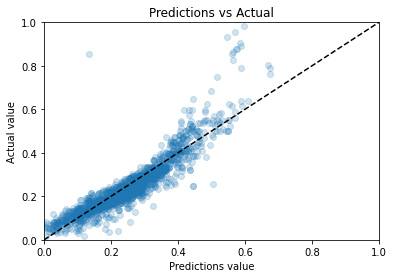

In [35]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.Figure(figsize=(10, 10))
plt.scatter(y_pred_lr, y_val, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [36]:
joblib.dump(lr_model, "trained_models/carprice_model_linear_regression.joblib")

['trained_models/carprice_model_linear_regression.joblib']

## **Train a Neural Network to predict car price**

In [37]:
from torch.utils.data import Dataset, DataLoader

# TODO: Create dataset from numpy array X, y
class CarPriceDataset(Dataset):
    def __init__(self, X, y = None):
        self.X = X
        if y is not None:
            self.y = y
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [41]:
# TODO: Create dataset and dataloader
train_dataset = CarPriceDataset(X_train, y_train)
val_dataset = CarPriceDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

x_sample, y_sample = next(iter(train_dataloader))
x_sample.shape, y_sample.shape

(torch.Size([32, 138]), torch.Size([32, 1]))

In [42]:
class CarPriceModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        # TODO: create a linear layer with input_size and output_size
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.linear(x)
        return x

In [43]:
n_features, n_output = X_train.shape[1], y_train.shape[1]
print(n_features)
model = CarPriceModel(input_size=n_features, output_size=n_output)
model

138


CarPriceModel(
  (linear): Linear(in_features=138, out_features=1, bias=True)
)

In [44]:
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn = nn.MSELoss(reduction='mean'),
    num_epochs = 100,
    update_frequency = 10,
):
    for epoch in tqdm(range(num_epochs)):
        # Set the model to training mode.
        model.train()
        for x, y in train_dataloader:
            # Forward pass.
            y_pred = model(x.float())
            # Calculate the loss.
            loss = loss_fn(y_pred, y.float())
            # Backward pass.
            loss.backward()
            # Update the model parameters.
            optimizer.step()
            # Reset the gradients.
            optimizer.zero_grad()

        # Set the model to evaluation mode and calculate the test loss at the end of each epoch.
        model.eval()
        with torch.no_grad():
            for x, y in test_dataloader:
                # Forward pass.
                y_pred = model(x.float())
                # Calculate the loss.
                loss = loss_fn(y_pred, y.float())

            # Print the loss if the epoch is a multiple of 10.
            if epoch % update_frequency == 0:
                print(f"Epoch {epoch}: {loss.item()}")

In [45]:
# Define the loss function and the optimizer.
learning_rate = 1e-3
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model.
num_epochs = 120
update_frequency = 10

train(
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = val_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    num_epochs = num_epochs,
    update_frequency = update_frequency,
)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0: 0.0067148092202842236
Epoch 10: 0.0006556630250997841
Epoch 20: 0.0007373413536697626
Epoch 30: 0.0008062653942033648
Epoch 40: 0.0008457532385364175
Epoch 50: 0.0008968344191089272
Epoch 60: 0.0012189785484224558
Epoch 70: 0.0007877585012465715
Epoch 80: 0.0009485146729275584
Epoch 90: 0.0009711619350127876
Epoch 100: 0.0009599439799785614
Epoch 110: 0.0008504953002557158


### Evaluate the model on the test set with Mean Squared Error

In [46]:
def predict(model, test_dataloader):
    model.eval()
    y_pred_list = []
    y_true_list = []
    for x, y in test_dataloader:
        y_pred = model(x.float())
        prediction = y_pred.detach().numpy()
        y = y.numpy()
        y_pred_list.extend(prediction)
        y_true_list.extend(y)
    y_pred_list = np.concatenate(y_pred_list)
    y_true_list = np.concatenate(y_true_list)
    return y_pred_list, y_true_list

In [47]:
# Get the predictions for the test set
y_pred, y_true = predict(model, val_dataloader)

In [48]:
mean_squared_error(y_true, y_pred)

0.0031721954056437938

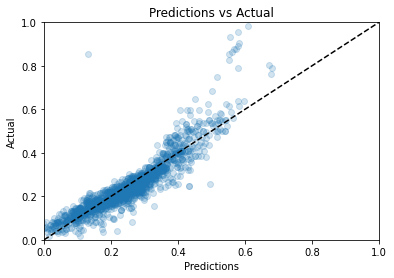

In [49]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(y_pred, y_true, alpha=0.2)

plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [50]:
torch.save(model.state_dict(), "trained_models/carprice_model_mse_0003.pth")

## **Train a Neural Network with multiple layers (MLP)**

In [52]:
class CarPriceTwoLayerModel(nn.Module):
    def __init__(self, input_size, output_size, intermediate_dim = 10):
        super().__init__()
        # TODOs: Create two layers neural network
        self.linear1 = nn.Linear(input_size, intermediate_dim)
        self.linear2 = nn.Linear(intermediate_dim, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

model_two_layers = CarPriceTwoLayerModel(input_size=n_features, output_size=n_output)
model_two_layers

CarPriceTwoLayerModel(
  (linear1): Linear(in_features=138, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [53]:
# Define the loss function and the optimizer.
learning_rate = 1e-3 # = 0.001
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model_two_layers.parameters(), lr=learning_rate)

# Train the model.
num_epochs = 120
update_frequency = 10

train(
    model=model_two_layers,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    num_epochs=num_epochs,
    update_frequency=update_frequency,
)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0: 0.005196358077228069
Epoch 10: 0.0006574511062353849
Epoch 20: 0.00026034205802716315
Epoch 30: 0.00021963345352560282
Epoch 40: 0.00013818910520058125
Epoch 50: 0.0003826949105132371
Epoch 60: 0.0007690826314501464
Epoch 70: 0.00037014545523561537
Epoch 80: 0.0003313032793812454
Epoch 90: 0.0006878391723148525
Epoch 100: 0.0006697083008475602
Epoch 110: 0.000481513881823048


In [54]:
y_test, y_true_dl = predict(model_two_layers, val_dataloader)
mse_score = mean_squared_error(y_test, y_true_dl)
mse_score

0.001550862382728419

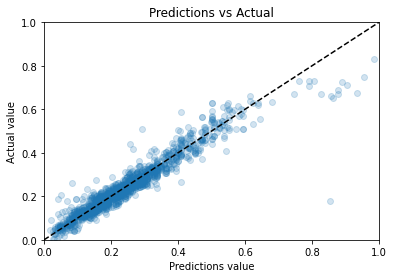

In [55]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(y_true_dl, y_test, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [57]:
torch.save(model_two_layers.state_dict(), f"trained_models/carprice_two_layer_model_mse_00015.pth")

## **Use the models to predict on new data**

- Create a model
- Load one-hot-encoder and scaler
- Transform dataframe
- Predict

In [62]:
import joblib
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [63]:
# load data (similar to previous code)

df = pd.read_csv(op.join("deep-learning-skooldio", "rodkaidee-dataset", "Rodkaidee Data.csv"))
df["Price"] = df["Price"].apply(lambda x: float(x.replace(",", "")))
df["Mileage"] = df["Mileage"].apply(lambda x: float(x.replace(",", "")))

_, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [64]:
# create model and load trained weights
class CarPriceTwoLayerModel(nn.Module):
    def __init__(self, input_size, output_size, intermediate_dim = 10):
        super().__init__()
        self.linear1 = nn.Linear(input_size, intermediate_dim)
        self.linear2 = nn.Linear(intermediate_dim, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

model = CarPriceTwoLayerModel(138, 1)
# TODO: load trained weights
model.load_state_dict(torch.load("trained_models/carprice_two_layer_model_mse_00015.pth"))

<All keys matched successfully>

In [65]:
# load one-hot encoder 
one_hot_encoder_path = "trained_models/one_hot_encoder.joblib"
year_scaler_path = "trained_models/year_scaler.joblib"
mileage_scaler_path = "trained_models/mileage_scaler.joblib"
price_scaler_path = "trained_models/price_scaler.joblib"

# TODO: Load one-hot encoder and scaler
ohe = joblib.load(one_hot_encoder_path)
year_scaler = joblib.load(year_scaler_path)
mileage_scaler = joblib.load(mileage_scaler_path)
price_scaler = joblib.load(price_scaler_path)

In [66]:
class CarPriceDataset(Dataset):
    def __init__(self, X, y = None):
        self.X = X
        if y is not None:
            self.y = y
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [67]:
# prepare test dataset
CAT_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]
X_test = np.hstack([
    ohe.transform(df_test[CAT_COLUMNS]),
    year_scaler.transform(df_test[["Year"]]),
    mileage_scaler.transform(df_test[["Mileage"]]),
])
test_dataset = CarPriceDataset(X_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [68]:
def predict(model, test_dataloader):
    model.eval()
    y_pred_list = []
    for x in test_dataloader:
        y_pred = model(x.float())
        prediction = y_pred.detach().numpy()
        y_pred_list.extend(prediction)
    y_pred_list = np.concatenate(y_pred_list)
    return y_pred_list

In [69]:
y_pred = predict(model, test_dataloader)
y_pred_price = price_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [72]:
df_test["Pred_Price"] = y_pred_price

In [73]:
df_test.head(10)

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color,Pred_Price
2759,Toyota,Vios,1.5,B-Segment,2015,62639.0,กรุงเทพมหานคร,338000.0,Gray,347095.562500
2846,Toyota,Altis,1.6,C-Segment,2015,65615.0,สงขลา,385000.0,Silver,378758.031250
6682,Honda,Civic,2.0,C-Segment,2007,203000.0,สิงห์บุรี,295000.0,Gray,281043.000000
3262,Toyota,Yaris,1.2,Eco Car,2014,124007.0,ราชบุรี,339000.0,White,331448.281250
486,Mazda,Mazda2,1.3,B-Segment,2019,51957.0,กรุงเทพมหานคร,439000.0,Blue,411042.468750
3616,Nissan,Sylphy,1.6,C-Segment,2013,120000.0,นนทบุรี,219000.0,Black,285597.656250
3590,Nissan,Almera,1.2,Eco Car,2013,130000.0,เชียงใหม่,199000.0,Black,217759.531250
3246,Toyota,Vios,1.5,B-Segment,2014,80000.0,เชียงใหม่,329000.0,Black,318516.625000
6503,Nissan,Tiida,1.6,C-Segment,2007,140000.0,นนทบุรี,128000.0,Black,127120.734375
7209,Honda,City,1.5,B-Segment,2003,166508.0,นครศรีธรรมราช,129000.0,Gold,124967.789062


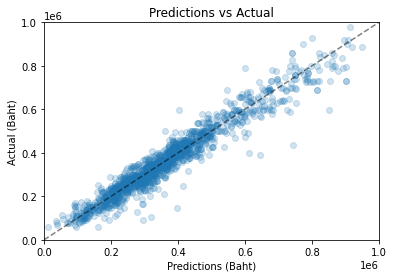

In [74]:
plt.plot([0, 1_000_000], [0, 1_000_000], color="black", alpha=0.5, linestyle="--")

plt.scatter(df_test["Pred_Price"].values, df_test["Price"], alpha=0.2)
plt.xlabel("Predictions (Baht)")
plt.ylabel("Actual (Baht)")
plt.title("Predictions vs Actual")

plt.xlim(0, 1_000_000)
plt.ylim(0, 1_000_000)
plt.show()